### 非线性最小二乘问题

非线性最小二乘法的一般形式：
$$f(x) = \frac{1}{2}\sum_{j=1}^{m}r_{j}^2(x)$$
写成矩阵形式: $f(x)=\frac{1}{2}||r(x)||^2_2$, 对于这种无约束问题, 前面介绍的任何一种无约束算法都可以解决它, 我们直接给出它的梯度和海瑟矩阵.
$$\nabla f(x) = J(x)^T r(x) \\
\nabla^2f(x)=J(x)^TJ(x)+\sum_{i=1}^{m}r_{i}(x)\nabla^2r_{i}(x)$$
其中$J(x)$是向量值函数$r(x)$在$x$处的雅克比矩阵。

### 高斯——牛顿算法
该算法直接使用$J(x)^{T}J(x)$作为海瑟矩阵的近似矩阵, 该算法产生的下降方向$d^{k}$满足
$$(J^k)^TJ^kd^k=-(J^k)^Tr^k$$
使用QR法解这个方程得到下降方向. 

![](1.png)

### Levenberg-Marquardt方法

#### 信頼域型LM方法
主要应用的场合是$(J^k)^TJ^k$奇异时，它仍然可以给出一个下降方向，LM方法每一步求解如下子问题：
$$\min_{d}\quad \frac{1}{2}||J^k+r^k||^2,\quad s.t. \quad ||d||\leq\Delta_K$$
事实上，LM方法将如下近似当做信頼域方法中的$m_k$：
$$m_{k}(d) = \frac{1}{2}||r^k||^2+d^T(J^k)^Tr^k+\frac{1}{2}d^T(J^k)^TJ^kd$$

#### LMF方法
每一步求解子问题：
$$\min_{d}\quad\frac{1}{2}||Jd+r||^2_2+ \lambda ||d||^2_2$$

设第$k$步产生的迭代方向为$d^k$，我们需要计算目标函数的预估下降量和实际下降量的比值$\rho_k$，来确定下一步信頼域半径的大小。这一比值可以通过
$$\rho_k = \frac{f(x^k)-f(x^k+d^k)}{m_{k}(0)-m_{k}(d^{k})}$$
计算得到。然后根据$\rho_k$的大小来更新$\lambda_k$，当乘子$\lambda_k$增大时，信頼域半径会变小，反之亦然。

![](2.png)

### 应用举例
问题模型为：
$$\min_{x\in C^n}\quad f(x)=\frac{1}{2}\sum_{j=1}^{m}(|\bar{a}_{j}^Tx|^2-b_j)^2$$

In [117]:
import numpy as np
from scipy import linalg

m = 10            # the amount of samples
n = 5             # the dim of sample   

A = np.random.randint(1,10, (m,n))
b = np.random.randint(1,10, m)


def sum_f(x):
    s = 0
    for i in range(m):
        s += ((A[i] @ x)**2 - b[i])**2
    return s
f = lambda x: (1/2) * sum_f(x)

def sum_grad_f(x):
    s = 0
    for i in range(m):
        s += ((A[i] @ x)**2 -b[i]) * A[i] * (A[i] @ x)
    return s
grad_f = lambda x: sum_grad_f(x)

r = lambda x: (A @ x)**2 - b

def j(x):
    j = np.ones((m,n))
    for i in range(m):
        j[i] = j[i]*((A@x)[i])
    return j
J = lambda x: 2*A*j(x)

M = lambda x,d: 0.5 * np.dot(r(x),r(x)) + np.dot(d, np.transpose(J(x))@r(x)) + 0.5 * np.dot(J(x)@d, J(x)@d)

$\nabla f(x)$那里感觉等式右边的系数应该有一个$2$的。

In [124]:
class nonlinear:
    def __init__(self, f, grad_f, r, J, step) -> None:
        self.f = f
        self.grad_f = grad_f
        self.step = step
        self.r = r
        self.J = J
    
    def Gauss_Newton(self):
        result = np.zeros(self.step)
        x = np.linspace(1, 10, n)
        for i in range(self.step):
            Q,R = linalg.qr(J(x))
            d = np.linalg.solve(np.transpose(R)@R, -np.transpose(Q@R)@r(x))
            alpha = 0.1   ## For simplicity, fix the size of step 
            x_next = x + alpha*d
            x = x_next
            result[i] = self.f(x)
        return result, x
    
    def LMF(self):
        result = np.zeros(self.step)
        x = np.linspace(1,10,n)
        Lambda = 1
        eta = 0.1
        rho1 = 0.25
        rho2 = 0.75
        gamma1 = 0.25
        gamma2 = 2
        for i in range(self.step):
            A = np.transpose(J(x))@J(x)+Lambda * np.eye(n)
            b = -np.transpose(J(x))@r(x)
            d = np.linalg.solve(A, b)
            rho = (self.f(x) - self.f(x+d))/(M(x,np.zeros(n)) - M(x,d))
            if (rho < rho1):
                Lambda = gamma2 * Lambda
            elif(rho > rho2):
                Lambda = gamma1 * Lambda
            if (rho > eta):
                x += d
            else:
                x = x
            result[i] = self.f(x)
        return result, x


In [137]:
Step = 100
sol = nonlinear(f,grad_f,r,J,Step)
result_Gauss_Newton = sol.Gauss_Newton()
result_LMF = sol.LMF()
import matplotlib.pyplot as plt
step = np.linspace(1, Step, Step)

先看LMF算法的效果图

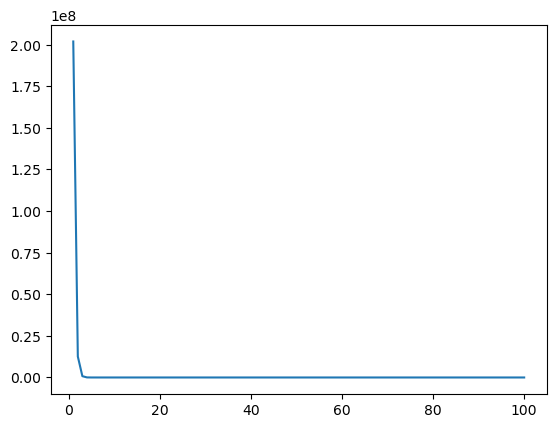

In [139]:
plt.plot(step, result_LMF[0])

接下来是高斯牛顿算法的效果图

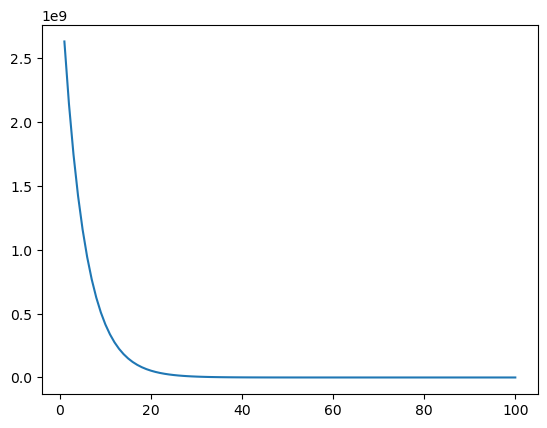

In [140]:
plt.plot(step, result_Gauss_Newton[0])